# Geospatial (Raster) data visualization with matplotlib

### Libraries

In [1]:
import rasterio 
from rasterio.plot import show, show_hist
import matplotlib.pyplot as plt
import geopandas as gpd
import folium
import numpy as np
import pandas as pd
from rasterio.features import shapes
from shapely.geometry import shape

### Data

In [10]:
# raster (continuous data)
im_loc = './data/20201119.tif'
ras = rasterio.open(im_loc)

In [11]:
# admin boundary (source: https://www.naturalearthdata.com/ )
world = gpd.read_file('./data/world-administrative-boundaries.geojson')
jpn = world[world['name']=='Japan']

### Single layer

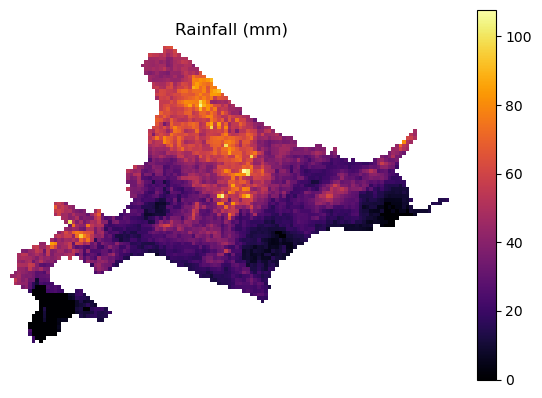

In [12]:
fig, ax1 = plt.subplots()

# instantiate image
im = show(ras, ax=ax1, cmap='inferno')

# add color bar
im = im.get_images()[0]
fig.colorbar(im, ax=ax1, fraction=0.058);

# add aesthetics
plt.axis('off')
plt.title('Rainfall (mm)');

### Histogram

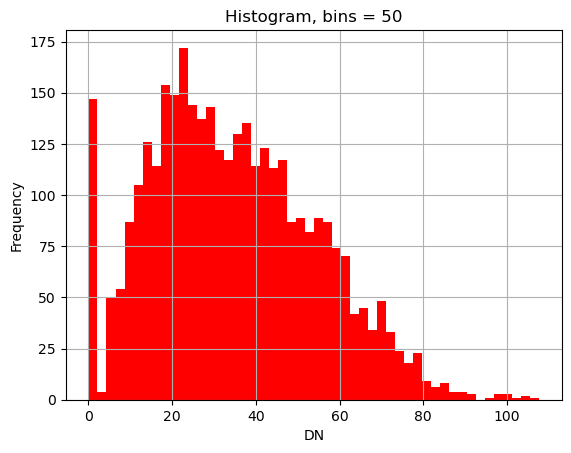

In [13]:
# create subplots for better control (e.g. remomve legend)
fig, ax = plt.subplots() 

# specify number of bins (for continuous data)
bins = 50

# show histogram
show_hist(ras, ax=ax, bins = bins)

# remove legend
ax.get_legend().remove()
ax.set_title(F'Histogram, bins = {bins}');

### Subplots

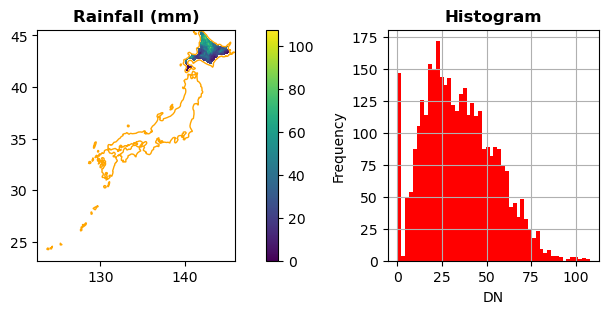

In [14]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,3), 
                               gridspec_kw={'width_ratios': [3, 1]})

# basic image
im = show(ras, ax=ax1, title='Rainfall (mm)')

# add color bar
im = im.get_images()[0]
fig.colorbar(im, ax=ax1, fraction=0.058)


# overlay shapefile
jpn.plot(ax=ax1, facecolor = 'None', edgecolor = 'orange')

# add histogram 
show_hist(ras, ax=ax2, bins=50)
ax2.get_legend().remove();

### Interactive map

#### Step 1: Convert raster to a geodataframe

In [15]:
with rasterio.open(im_loc) as src:
    data = src.read(1, masked=True)

    # shape generator
    shape_gen = ((shape(s), v) for s, v in shapes(data, transform=src.transform))

    # build a pandas dataframe
    df = pd.DataFrame(shape_gen, columns=['geometry', 'rainfall'])
    gdf = gpd.GeoDataFrame(df["rainfall"], geometry=df.geometry, crs=src.crs)    

# reset index to get the index as a column
gdf_i = gdf.reset_index()

#### Step 2: Add geodataframe on interative map

In [16]:
# create an empty map
m = folium.Map(location=[43, 143], zoom_start=5, tiles="cartodbpositron")

# define threshold params
threshold_scale = (gdf_i['rainfall'].quantile((0,0.2,0.4,0.6,0.8,1))).tolist()

# generate a choropleth
folium.Choropleth(geo_data = gdf_i, 
                  data = gdf_i, 
                  columns = ['index','rainfall'],
                  key_on ='feature.properties.index', name = 'choropleth',
                  fill_opacity=0.7,
                  line_opacity=0.01,
                  line_width = 0.001,
                  fill_color="RdPu",
                  threshold_scale=threshold_scale).add_to(m)

# add layer control widget
folium.LayerControl().add_to(m)

m